In [4]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-11-2022)


In [5]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PowerLawNuisanceSpectralModel,
    PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

In [6]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_load = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_load = dataset_load.downsample(4)

## Single Cases

In [7]:
true_energy = dataset_load.exposure.geom.axes[0].center.value

e_reco = 0.1
print(e_reco)

0.1


In [8]:
sys_d_cor = sys_dataset(dataset_asimov= dataset_load,
                        shift = 0, 
                        tilt = 0,
                        rnd = False)
dataset_N = sys_d_cor.create_dataset_N()
dataset = sys_d_cor.create_dataset()
dataset_input = sys_d_cor.create_dataset()


with dataset_N.models.parameters.restore_status(): 
    dataset_N.models.parameters['e_reco'].value = e_reco
    dataset.counts = dataset_N.npred()
    dataset_N.counts = dataset_N.npred()


sigma_e = 0.1

penalising_covmatrix = [[1/sigma_e**2]]
penalising_invcovmatrix =  penalising_covmatrix
dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
#dataset_asimov.models.parameters['e_reco'].value = e_reco



In [9]:
%%time
fit = Fit(store_trace=False)
result = fit.run(dataset)


CPU times: user 2.65 s, sys: 38.2 ms, total: 2.68 s
Wall time: 2.69 s


In [10]:
%%time
fit_N = Fit(store_trace=False)
result_N = fit_N.run(dataset_N)


CPU times: user 1.6 s, sys: 17.3 ms, total: 1.62 s
Wall time: 1.62 s


## Correlation

In [11]:
from gammapy.modeling.fit import Registry
registry= Registry()

def covariance_ (fit_compute, datasets_compute):
    #parameters = Parameters.from_stack([datasets_compute.models.parameters])
    parameters = datasets_compute.models.parameters
    parameters = parameters.free_parameters

    kwargs = fit_compute.covariance_opts.copy()
    kwargs["minuit"] = fit_compute.minuit
    backend = kwargs.pop("backend", fit_compute.backend)
    compute = registry.get("covariance", backend)

    with parameters.restore_status():
        if fit_compute.backend == "minuit":
            method = "hesse"
        else:
            method = ""
        factor_matrix, info = compute(
            parameters=parameters, function=datasets_compute.stat_sum, **kwargs
        )
        covariance = Covariance.from_factor_matrix(
            parameters=parameters, matrix=factor_matrix
        )

        #covariance = covariance.get_subcovariance(datasets_compute.models.parameters)
    return covariance

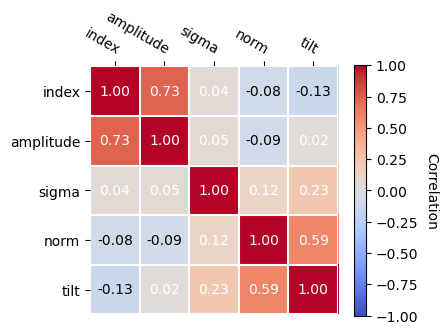

In [12]:
covariance  = covariance_(fit, dataset)
covariance.plot_correlation()


fig = plt.gcf()
fig.savefig("plots/3_corr_matrix_standard.png")

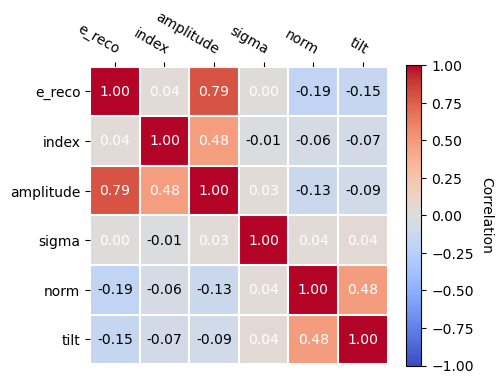

In [13]:
covariance_N  = covariance_(fit_N, dataset_N)
covariance_N.plot_correlation()


fig = plt.gcf()
fig.savefig("plots/3_corr_matrix_nuisance.png")

In [14]:
print(dataset_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : SourceN
  Datasets names            : None
  Spectral model type       : E_Reco
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    e_reco                        :      0.002   +/-    0.09             
    index                         :      2.301   +/-    0.07             
    amplitude                     :   8.87e-13   +/- 1.5e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                         :      0.020   +/-    0.01 deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spe